# Regression modelling using multi-spectral aerial images: A case study using ``homnim``

This notebook shows how `homonim` can help improve regression modelling performance.  It works with aerial imagery and ground truth data from a [study](https://github.com/dugalh/map_thicket_agc) that investigated aboveground carbon (AGC) mapping in the thicket biome, South Africa.  

## Setup

### Install dependencies

This notebook uses the `geedim`, `geopandas`, `gdal` and `matplotlib` packages.  You can uncomment the cell below to install them, if they aren't installed already.

In [ ]:
# import sys
# if 'conda' in sys.prefix:
#     # install into the conda environment the notebook is being run from
#     !conda install --yes --prefix {sys.prefix} -c conda-forge geedim geopandas gdal matplotlib
# else:
#     # install into the conda environment the notebook is being run from
#     !{sys.executable} -m pip install geedim geopandas gdal matplotlib

In [14]:
# imports used by more than one cell
import logging
from pathlib import Path
from matplotlib import pyplot
import numpy as np
import rasterio as rio
from tqdm.auto import tqdm

import geedim as gd

logging.basicConfig(level=logging.ERROR)

### Download aerial images

The aerial imagery consists of 4 50cm resolution, 4 band images, captured on 8-9 May 2015, covering a small site in the Baviaanskloof.  The images are orthorecified but otherwise unadjusted i.e. without colour balancing, gamma correction etc.  Imagery was captured and supplied by [National Geo-spatial Information (NGI)](https://ngi.dalrrd.gov.za/index.php/what-we-do/aerial-photography-and-imagery).

In this step, we create an *images* sub-folder, then download & extract the [source aerial images](https://zenodo.org/record/7114702) into it.  It is a large download (~2 GB), so you may want to do it manually.  Alternatively, run the code segment below.  

In [ ]:
from zipfile import ZipFile
from urllib import request

# src_url = 'https://zenodo.org/record/7114702/files/Ngi_May2015_Source.zip'
src_url = 'https://github.com/dugalh/geedim/archive/refs/tags/v1.5.3.zip'
images_path = Path('images')
images_path.mkdir(exist_ok=True)
zip_path = images_path.joinpath('temp.zip')
zip_path = Path(r"V:\Data\HomonimEgs\NGI_3323D_2015_GefSite\Scratch\Ngi_May2015_Corrected.zip")

# download zip file
response = request.urlopen(src_url)
with tqdm(
    total=response.length, desc='Download', unit='B', unit_scale=True, 
    dynamic_ncols=True
) as pbar, open(zip_path, 'wb')  as fout:
    for chunk in response:
        fout.write(chunk)
        pbar.update(len(chunk))

# extract zip file
with ZipFile(zip_path) as zip_file:
     for file in tqdm(
        zip_file.namelist(), desc='Extract', dynamic_ncols=True
    ):
        zip_file.extract(member=file, path=images_path)

## Correct the aerial imagery to surface reflectance

### Search for reference image

Now we search for a Sentinel-2 reference image using ``geedim``.  Sentinel-2 is generaly a good reference choice, and was selected for this example because it has bands that are spectrally similar to the aerial image bands, and a relatively high spatial resolution (10m).  Normally it is best to search for a reference image that is concurrent with the source imagery, but the Sentinel-2 archive only starts after the source capture date (8-9 May 2015).  So, here we search for the soonest possible reference after this date.  Thicket vegetation is slow growing and the study site was undisturbed over the time between the aerial and Sentinel-2 captures, so there is little change between source and reference images.

In [ ]:
gd.Initialize()
src_mosaic_path = Path('images/Ngi_May2015_OrthoNgiDem_Source_Mosaic.vrt')

# create a search region that covers the source image mosaic
region = gd.utils.get_bounds(src_mosaic_path)

# create and search the Sentinel-2 collection
s2_coll = gd.MaskedCollection.from_name('COPERNICUS/S2')
s2_coll = s2_coll.search('2015-05-08', '2015-10-30', region)
print('Image property descriptions:\n\n' + s2_coll.schema_table)
print('Search Results:\n\n' + s2_coll.properties_table)

# equivalent geedim command line:
#!geedim search -c s2-toa -s 2015-05-08 -e 2015-10-30 -r {src_mosaic_path}

### Download reference image

Let's download the first 100% cloudless image, *COPERNICUS/S2/20151023T081112_20151023T081949_T34HGH*.

In [6]:
ref_path = Path('images/s2_reference.tif')
gd_image = gd.MaskedImage.from_id('COPERNICUS/S2/20151023T081112_20151023T081949_T34HGH', mask=True)
gd_image.download(ref_path, region=region, overwrite=True)

# equivalent geedim command line:
# !geedim download -i COPERNICUS/S2/20151023T081112_20151023T081949_T34HGH --mask -r {src_file}

EEException: Earth Engine client library not initialized. Run `ee.Initialize()`

## Correct the aerial images to surface reflectance

Next, we correct the aerial images by fusion with the Sentinel-2 reference. For this, we use `homonim`'s *RasterFuse* class, a kernel size of 15x15 pixels and the *gain-blk-offset* model.

In [7]:
from homonim import RasterFuse, Model

# paths to source aerial images
src_paths = [
    Path(f'images/3323d_2015_1001_02_00{i}_RGBN_CMP.tif') 
    for i in [76, 78, 80, 81]
]
# paths to corrected images to create
corr_paths = [
    src_path.parent.joinpath(f'{src_path.stem}_FUSE.tif')
    for src_path in src_paths
]
# sentinel-2 bands that correpond to the red, green, blue and near-infrared bands of 
# the aerial images
ref_bands = [4, 3, 2, 8]

for src_path, corr_path in zip(src_paths, corr_paths):
    with RasterFuse(
        src_path, ref_path, ref_bands=ref_bands
    ) as raster_fuse:
        raster_fuse.process(
            corr_path, Model.gain_blk_offset, (15, 15), overwrite=True,
        ) 

# equivalent homonim command line:
# !homonim fuse -m gain-blk-offset -k 15 15 -rb 4 -rb 3 -rb 2 -rb 8 -mp -od images {src_file} {ref_file}

Source and reference image will be re-projected to the same CRS: 3323d_2015_1001_02_0076_RGBN_CMP.tif and s2_reference.tif


  0%|          |0/8 blocks [00:00<?]

KeyboardInterrupt: 

Next, we create a VRT mosaic of the corrected images to use in the visualisation and evaluation steps.

In [4]:
from osgeo import gdal

# strictly, one should avoid using GDAL and rasterio together, but it doesn't
# create conflicts here
corr_mosaic_path = Path('images/Ngi_May2015_OrthoNgiDem_Corrected_Mosaic.vrt')
_ = gdal.BuildVRT(
    str(corr_mosaic_path.absolute()), [str(cp) for cp in corr_paths]
)

NameError: name 'corr_paths' is not defined

## Visualise

First we load the AGC ground truth into a `geopandas` *GeoDataFrame*.

In [2]:
import geopandas as gpd
plot_agc_gdf = gpd.GeoDataFrame.from_file(
    'https://raw.githubusercontent.com/dugalh/map_thicket_agc/main/'
    'data/outputs/geospatial/gef_plot_polygons_with_agc_v2.gpkg' 
)
# plot_agc_gdf = gpd.GeoDataFrame.from_file(
#     "C:\Data\Development\Projects\map_thicket_agc\data\outputs\geospatial\gef_plot_polygons_with_agc_v2.gpkg"
# )

Now, we display the AGC ground truth values and locations over the corrected mosaic.

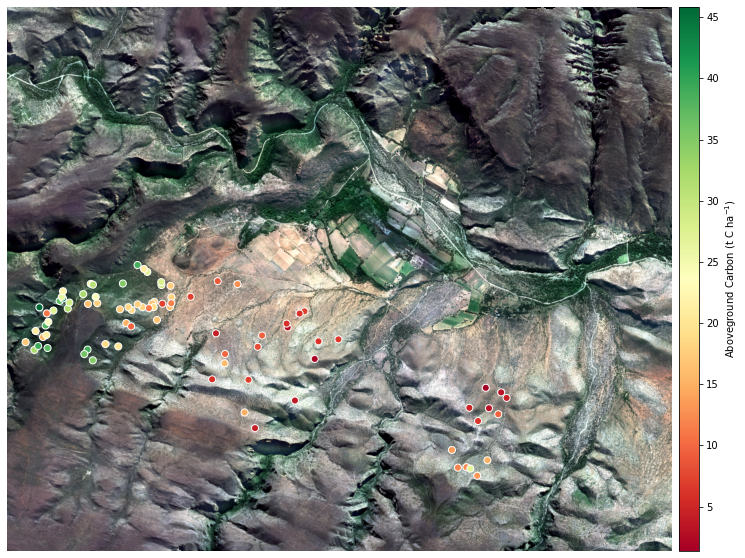

In [10]:
from rasterio.plot import show
from mpl_toolkits.axes_grid1 import make_axes_locatable

indexes = [1, 2, 3]
ds_fact = 4  # downsample factor

fig, ax = pyplot.subplots(1, 1, figsize=(20, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.1)

with rio.open(corr_mosaic_path, 'r') as corr_ds:
    ds_shape = tuple(np.round(np.array(corr_ds.shape) / ds_fact).astype(int).tolist())
    array = corr_ds.read(indexes=indexes, out_dtype='float32', out_shape=ds_shape)  # , resampling=Resampling.average)
    mask = np.any(array == corr_ds.nodata, axis=(0)) | np.any(np.isnan(array), axis=(0))
    array[:, mask] = np.nan
    for bi in range(len(indexes)):
        array[bi] -= np.nanpercentile(array[bi], 2)
        array[bi] /= np.nanpercentile(array[bi], 98)
        array[bi] = np.clip(array[bi], 0, 1)

    transform = corr_ds.transform * rio.Affine.scale(ds_fact)
    ax = show(array, transform=transform, interpolation='bilinear', ax=ax)
    _plot_agc_gdf = plot_agc_gdf.to_crs(corr_ds.crs)
    _plot_agc_gdf.geometry = _plot_agc_gdf.geometry.centroid
    _plot_agc_gdf.AgcHa /= 1000
    ax = _plot_agc_gdf.plot(
        'AgcHa', kind='geo', legend=True, ax=ax, cmap='RdYlGn', cax=cax, edgecolor='white', 
        legend_kwds=dict(label='Aboveground Carbon (t C ha$^{-1}$)', orientation='vertical'),
        linewidth=1, markersize=50, 
    )
    ax.axis((86494.06047619047, 94313.07562770562, -3717680.7510822513, -3711286.8766233767))
    ax.axis('off')

## Evaluate

The evaluation compares the correlation of source and corrected *NDVI* with AGC ground truth.  From this, we have a basic indication of the improvement in the relevance, or explanatory power of the image due to surface reflectance correction.

### Find NDVI

here we find the mean NDVI values for each ground truth plot, for both source and corrected images.

In [15]:
from rasterio import features, windows
from homonim import utils

src_mosaic_path = Path('images/Ngi_May2015_OrthoNgiDem_Source_Mosaic.vrt')

ndvis = []
for im_path in [src_mosaic_path, corr_mosaic_path]:    
    ndvi = []
    with rio.open(im_path, 'r') as ds:        
        # loop over ground truth plot ids and geometries
        for id, plot in tqdm(
            plot_agc_gdf.to_crs(ds.crs).iterrows(), total=plot_agc_gdf.shape[0],
            desc=im_path.name, 
        ):
            # find a rasterio window that contains the plot polygon
            bounds = features.bounds(plot.geometry)
            win = windows.from_bounds(*bounds, transform=ds.transform)
            win = utils.expand_window_to_grid(win)
            
            # read the image array corresponding to the plot window
            array = ds.read(out_dtype='float64', window=win)

            # find a mask for pixels contained inside the plot
            win_transform = ds.window_transform(win)
            mask = ~features.geometry_mask(
                plot.geometry, (win.height, win.width), transform=win_transform
            )

            # find mean NDVI for the plot
            r = array[0, mask]
            nir = array[3, mask]
            ndvi.append(np.mean((nir - r) / (nir + r)))

    ndvis.append(ndvi)

ndvi_dict = dict(zip(['Source', 'Corrected'], ndvis))

Ngi_May2015_OrthoNgiDem_Source_Mosaic.vrt:   0%|          | 0/85 [00:00<?, ?it/s]

c:\Users\dugalh\.conda\envs\py310_geospatial\lib\site-packages\rasterio\features.py:288: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
c:\Users\dugalh\.conda\envs\py310_geospatial\lib\site-packages\rasterio\features.py:288: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
c:\Users\dugalh\.conda\envs\py310_geospatial\lib\site-packages\rasterio\features.py:288: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
c:\Users\dugalh\.conda

Ngi_May2015_OrthoNgiDem_Corrected_Mosaic.vrt:   0%|          | 0/85 [00:00<?, ?it/s]

c:\Users\dugalh\.conda\envs\py310_geospatial\lib\site-packages\rasterio\features.py:288: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
c:\Users\dugalh\.conda\envs\py310_geospatial\lib\site-packages\rasterio\features.py:288: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
c:\Users\dugalh\.conda\envs\py310_geospatial\lib\site-packages\rasterio\features.py:288: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
c:\Users\dugalh\.conda

Finally, we create scatter plots of source / corrected NDVI vs. AGC, and display the corresponding *R*<sup>2</sup> correlation coefficients.

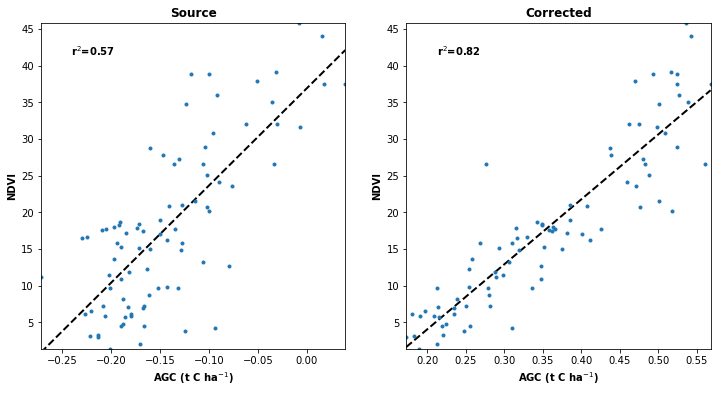

In [13]:

fig, axes = pyplot.subplots(1, 2, figsize=(12, 6))
agc = plot_agc_gdf.AgcHa / 1000
for ax, (label, ndvi) in zip(axes, ndvi_dict.items()):
    # plot NDVI vs AGC scattter
    ax.plot(ndvi, agc, '.')

    # find and plot regression line
    coeff, _, _, _ = np.linalg.lstsq(
        np.array([ndvi, np.ones(len(ndvi))]).T, agc, rcond=None
    )
    xlim = [np.min(ndvi), np.max(ndvi)]
    ylim = [np.min(agc), np.max(agc)]    
    yr = np.array(xlim) * coeff[0] + coeff[1]
    ax.plot(xlim, yr, 'k--', lw=2, zorder=-1)
    
    # find R2 correlation coefficient and add to plot
    r2 = np.corrcoef(agc, ndvi)[0, 1] **2
    ax.text(
        .1, 0.9, f'r$^{2}$={r2:.2f}', fontweight='bold', 
        transform=ax.transAxes
    )

    ax.set_xlabel('AGC (t C ha$^{-1}$)', fontweight='bold')
    ax.set_ylabel('NDVI', fontweight='bold')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim) 
    ax.set_title(label, fontweight='bold')